# ERA5 Wind Field Demonstration Notebook

In [1]:
import sys
sys.path.append('../')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import cos, radians
from datetime import datetime
from env.ERA_wind_field import WindField

## Description of dataset in NetCDF4 format

It contains
- data samples obtained from 2024-07-01 00:00 to 2024-07-05 23:00 (hourly data)
- pressure levels: 100 hPa, 200 hPa, 300 hPa, 500 hPa, 700 hPa, 850 hPa, 1000 hPa
- latitude : 0.0 ~ 90.0 (with interval 0.25)
- longitude : -180.0 ~ 179.75 (with interval 0.25)
- u/v component of wind vector for each (valid_time, pressure_level, latitude, longitude)

In [2]:
datapath = "../era5_data.nc"

In [3]:
ds = xr.open_dataset(datapath, engine='netcdf4')
print(ds)

<xarray.Dataset> Size: 3GB
Dimensions:         (valid_time: 120, pressure_level: 7, latitude: 361,
                     longitude: 1440)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 960B 2024-07-01 ... 2024-07-0...
  * pressure_level  (pressure_level) float64 56B 1e+03 850.0 ... 200.0 100.0
  * latitude        (latitude) float64 3kB 90.0 89.75 89.5 ... 0.5 0.25 0.0
  * longitude       (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    expver          (valid_time) <U4 2kB ...
Data variables:
    u               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
    v               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
  

In [4]:
## examples

ds.valid_time[:10]

<xarray.DataArray 'valid_time' (valid_time: 10)> Size: 80B
array(['2024-07-01T00:00:00.000000000', '2024-07-01T01:00:00.000000000',
       '2024-07-01T02:00:00.000000000', '2024-07-01T03:00:00.000000000',
       '2024-07-01T04:00:00.000000000', '2024-07-01T05:00:00.000000000',
       '2024-07-01T06:00:00.000000000', '2024-07-01T07:00:00.000000000',
       '2024-07-01T08:00:00.000000000', '2024-07-01T09:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 80B 2024-07-01 ... 2024-07-01T09:...
    expver      (valid_time) <U4 160B ...
Attributes:
    long_name:      time
    standard_name:  time

In [5]:
ds.pressure_level

<xarray.DataArray 'pressure_level' (pressure_level: 7)> Size: 56B
array([1000.,  850.,  700.,  500.,  300.,  200.,  100.])
Coordinates:
    number          int64 8B ...
  * pressure_level  (pressure_level) float64 56B 1e+03 850.0 ... 200.0 100.0
Attributes:
    long_name:         pressure
    units:             hPa
    positive:          down
    stored_direction:  decreasing
    standard_name:     air_pressure

## Plot a wind field at a certain time/pressure level

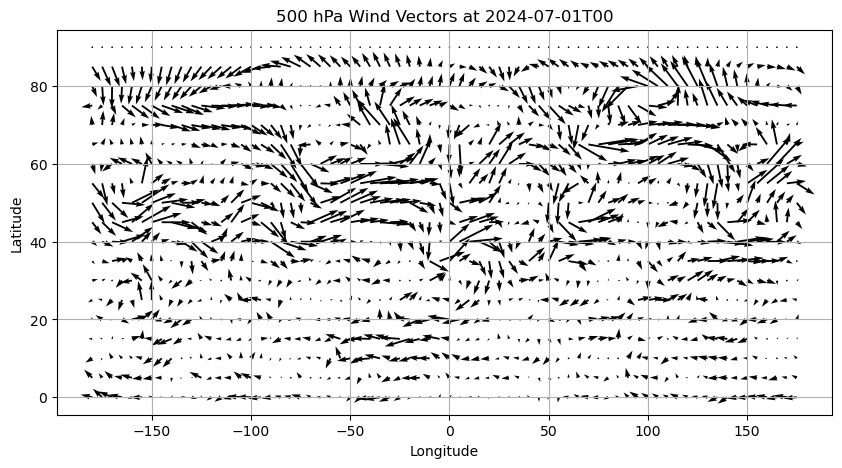

In [6]:
# 1. Pick a pressure level (hPa) and time index
plev = ds.pressure_level[3]     # hPa
tidx = 0                        # first time step

# 2. Extract the u/v wind components and longitude/latitude coordinates
u = ds.u.sel(pressure_level=plev).isel(valid_time=tidx)
v = ds.v.sel(pressure_level=plev).isel(valid_time=tidx)
lons = ds.longitude
lats = ds.latitude

# 3. Downsample for readability
step = 20
u2 = u.values[::step, ::step]
v2 = v.values[::step, ::step]
lon2 = lons.values[::step]
lat2 = lats.values[::step]

# 4. Build a title string with the datetime
time_str = np.datetime_as_string(ds.valid_time.values[tidx], unit='h')

# 5. Plot
plt.figure(figsize=(10, 5))
plt.quiver(lon2, lat2, u2, v2, scale=700)                   # adjust scale to taste
plt.title(f"{int(plev)} hPa Wind Vectors at {time_str}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


## Draw a (noisy) wind vector via interpolation

In [7]:
# 1. pick a reference start_time (should match your dataset’s first valid_time)
start_time = datetime(2024, 7, 1, 0, 0)

# 2. wrap it, giving an explicit seed for reproducibility
start = time.time()
wf = WindField(ds, start_time, add_noise=False)
end = time.time()
print(f"WindField initialized for {end - start:.4f} seconds. \n")

# 3. query at (lon, lat, pressure, elapsed_time)
start = time.time()
wf.disable_noise()
pt = wf.get_wind(
    lon          = -75.04,
    lat          =  40.33,
    pressure     =  400.0,
    elapsed_time =  1.3  # in hours
)
end=time.time()
print(f"Noiseless: u={pt.u:.2f}, v={pt.v:.2f}")
print(f"Elapsed: {end - start:.4f} seconds")
print('\n')

wf.enable_noise(noise_seed=None)
print("Noisy Samples")
for i in range(5):
    start = time.time()
    wf.reset_noise(noise_seed=i)   # picks a fresh random seed internally
    pt = wf.get_wind(
        lon          = -75.04,
        lat          =  40.33,
        pressure     =  400.0,
        elapsed_time =  1.3  # in hours
    )
    end=time.time()
    print(f"draw {i+1}: u={pt.u:.2f}, v={pt.v:.2f}")
    print(f"Elapsed: {end - start:.4f} seconds\n")

WindField initialized with noise enabled: False
WindField initialized for 28.7767 seconds. 

Noiseless: u=28.24, v=7.70
Elapsed: 0.0012 seconds


Noisy Samples
draw 1: u=27.49, v=6.28
Elapsed: 0.0227 seconds

draw 2: u=27.61, v=8.13
Elapsed: 0.0237 seconds

draw 3: u=29.28, v=7.13
Elapsed: 0.0208 seconds

draw 4: u=31.84, v=8.93
Elapsed: 0.0206 seconds

draw 5: u=28.75, v=8.55
Elapsed: 0.0225 seconds



## How a balloon/particle would move at a fixed pressure level without its physics

- Plot trajectory of a balloon given an initial position.
- No physical concept on the balloon.
- Note: altitude can be transformed into pressure_level with some parameters.

In [8]:
# transformation: altitude -> pressure
def altitude_to_pressure(altitude_m: float) -> float:
    """
    Calculate pressure at given altitude using the barometric formula.

    Args:
        altitude_m: Altitude in meters

    Returns:
        pressure: Pressure in hectopascals (hPa)

    Formula: P = P₀ * exp(-Mgh/RT)
    where:
    - P₀ = sea level pressure (1013.25 hPa)
    - M = molar mass of air (0.02896 kg/mol)
    - g = gravitational acceleration (9.81 m/s²)
    - h = height above sea level (m)
    - R = universal gas constant (8.314 J/(mol·K))
    - T = temperature (K)
    """
    # Constants
    P0 = 1013.25  # Sea level pressure (hPa)
    M = 0.02896   # Molar mass of air (kg/mol)
    g = 9.81      # Gravitational acceleration (m/s²)
    R = 8.314     # Universal gas constant (J/(mol·K))

    # Temperature varies with altitude
    # Using a simple linear lapse rate model
    T0 = 288.15   # Sea level temperature (K)
    L = 0.0065    # Temperature lapse rate (K/m)
    T = T0 - L * altitude_m  # Temperature at altitude

    # Calculate pressure using barometric formula
    pressure = P0 * np.exp(-M * g * altitude_m / (R * T))

    return pressure

WindField initialized with noise enabled: False


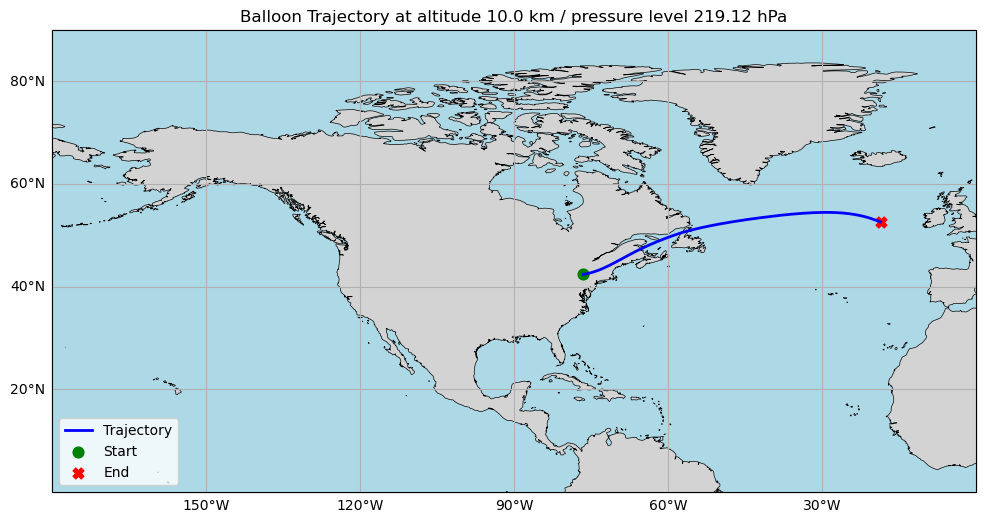

In [9]:
# --- PARAMETERS ---
altitude = 10000  # in meters (m)
pressure_level = altitude_to_pressure(altitude) # in hPa
initial_lon, initial_lat = -76.5, 42.4  # Initial point (Ithaca) (degrees)
duration_seconds = 24 * 3600       # total integration time (e.g. 24 h)
dt_seconds = 60                 # time step for integration (e.g. 1 h = 3600 s)

# --- SET UP WIND FIELD ---
start_time_np = ds.valid_time.values[0]
start_time = pd.to_datetime(start_time_np).to_pydatetime()
wf = WindField(ds, start_time=start_time, add_noise=False)
wf.disable_noise()

# --- SIMULATE TRAJECTORY ---
n_steps = int(duration_seconds / dt_seconds)
trajectory = [(initial_lon, initial_lat)]
lon, lat = initial_lon, initial_lat

for i in range(n_steps):
    elapsed = i * dt_seconds / 3600
    w = wf.get_wind(lon, lat, pressure_level, elapsed)  # WindVector(u, v) in m/s

    # Use dt in seconds directly
    dx_km = w.u * dt_seconds / 1000.0
    dy_km = w.v * dt_seconds / 1000.0

    # Convert km → degrees
    dlat = dy_km / 111.0
    dlon = dx_km / (111.0 * cos(radians(lat)))

    lon += dlon
    lat += dlat
    trajectory.append((lon, lat))

lons, lats = zip(*trajectory)

fig, ax = plt.subplots(
    figsize=(12,6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

ax = plt.axes(projection=ccrs.PlateCarree())

# around the North America
lon_min, lon_max = -180, 0
lat_min, lat_max = 0, 90
ax.set_extent([lon_min, lon_max, lat_min, lat_max],
              crs=ccrs.PlateCarree())

# add background
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue')
ax.coastlines('50m', linewidth=0.5)

# gridlines with labels
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

# plot trajectory
ax.plot(lons, lats,
        transform=ccrs.PlateCarree(),
        color='blue', linewidth=2,
        label='Trajectory')

# start and end markers
ax.scatter(lons[0], lats[0],
           transform=ccrs.PlateCarree(),
           color='green', marker='o', s=60,
           label='Start')
ax.scatter(lons[-1], lats[-1],
           transform=ccrs.PlateCarree(),
           color='red', marker='X', s=60,
           label='End')

ax.set_title(f"Balloon Trajectory at altitude {altitude/1000:.1f} km / pressure level {pressure_level:.2f} hPa")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.legend(loc='lower left')

plt.show()

## How a balloon/particle would move given an altitude profile without its physics

- Plot trajectory of a balloon given an initial position.
- No physical concept on the balloon.

WindField initialized with noise enabled: False


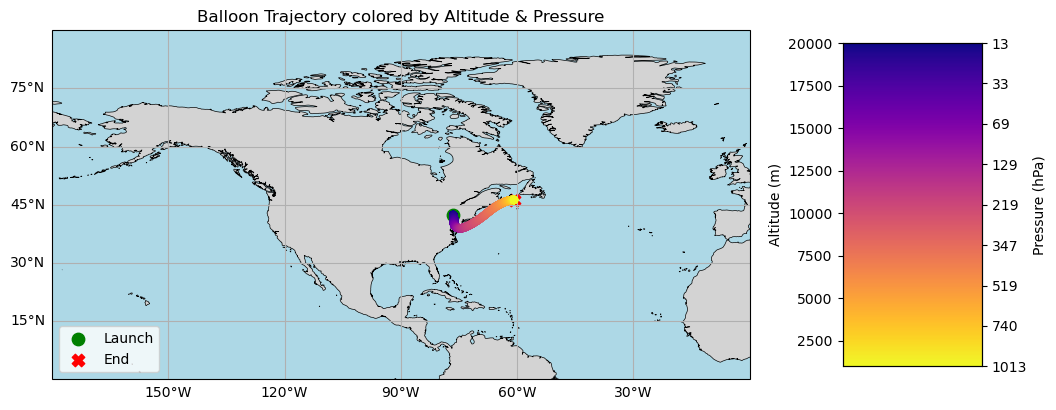

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import cos, radians
import pandas as pd

# ─── PARAMETERS & PROFILES ───
duration_seconds  = 24*3600
dt_seconds        = 60
n_steps           = int(duration_seconds / dt_seconds)

# altitude profile (m): you provided
altitude_profile  = np.linspace(20000, 1000, n_steps+1)

# barometric conversion
def altitude_to_pressure(alt_m):
    P0, M, g, R = 1013.25, 0.02896, 9.81, 8.314
    T = 288.15 - 0.0065*alt_m
    return P0 * np.exp(-M*g*alt_m/(R*T))

# compute pressure_profile if you need it elsewhere
pressure_profile = altitude_to_pressure(altitude_profile)


# ─── SIMULATE TRAJECTORY ───
initial_lon, initial_lat = -76.5, 42.4
start_time = pd.to_datetime(ds.valid_time.values[0]).to_pydatetime()
wf = WindField(ds, start_time=start_time, add_noise=False)
wf.disable_noise()

trajectory = [(initial_lon, initial_lat)]
lon, lat = initial_lon, initial_lat

for i in range(n_steps):
    elapsed_h = (i*dt_seconds)/3600.0
    alt_m     = altitude_profile[i]
    plev      = altitude_to_pressure(alt_m)
    w         = wf.get_wind(lon, lat, plev, elapsed_h)
    dx_km     = w.u * dt_seconds / 1000.0
    dy_km     = w.v * dt_seconds / 1000.0
    dlat      = dy_km / 111.0
    dlon      = dx_km / (111.0 * cos(radians(lat)))
    lon += dlon;  lat += dlat
    trajectory.append((lon, lat))

lons, lats = zip(*trajectory)


# ─── PLOT ON 2D NORTHERN HEMISPHERE ───
fig = plt.figure(figsize=(12,6))
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 0, 0, 90], crs=ccrs.PlateCarree())

# background
ax.add_feature(cfeature.LAND.with_scale('50m'),  facecolor='lightgray')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue')
ax.coastlines('50m', linewidth=0.5)
gl = ax.gridlines(draw_labels=True, dms=True,
                  xlocs=range(-180,1,30), ylocs=range(0,91,15))
gl.top_labels   = False
gl.right_labels = False

# path in grey
ax.plot(lons, lats,
        transform=ccrs.PlateCarree(),
        color='gray', linewidth=1, alpha=0.7)

# scatter by altitude
sc = ax.scatter(lons, lats,
                c=altitude_profile,
                cmap='plasma_r',
                s=25,
                transform=ccrs.PlateCarree(),
                zorder=5)

# start/end markers
ax.scatter(lons[0], lats[0],
           transform=ccrs.PlateCarree(),
           color='green', marker='o', s=80,
           label='Launch')
ax.scatter(lons[-1], lats[-1],
           transform=ccrs.PlateCarree(),
           color='red', marker='X', s=80,
           label='End')

# ─── SINGLE COLORBAR WITH DUAL AXES ───
cbar = fig.colorbar(sc, ax=ax,
                    orientation='vertical',
                    pad=0.1, shrink=0.7)
cbar.set_label("Altitude (m)")
cbar.ax.yaxis.set_label_position('left')
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_tick_params(labelleft=True, labelright=False)

# twin its axis to show pressure on the right
secax = cbar.ax.twinx()
# use the same tick locations as the altitude axis
alt_ticks = cbar.get_ticks()
pres_ticks = altitude_to_pressure(alt_ticks)
secax.set_yticks(alt_ticks)
secax.set_yticklabels([f"{p:.0f}" for p in pres_ticks])
secax.set_ylabel("Pressure (hPa)")
secax.yaxis.set_ticks_position('right')
secax.yaxis.set_label_position('right')

ax.set_title("Balloon Trajectory colored by Altitude & Pressure")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.legend(loc='lower left')

plt.show()
